# Dataset Information
Our training dataset contains information from 12,165 hours over 731 days with 14 features (information categories) and 1 target for each hour. The file named train.csv contains the training set of the problem, while the file test.csv contains the test set of the problem. Each line of these two files corresponds to a bike sharing record characterized by the following variables:

Variable | Description --- | --- | --- season | season (1:winter, 2:spring, 3:summer, 4:fall) yr | year (0: 2011, 1:2012) mnth | month (1 to 12) hr | hour (0 to 23) holiday | weather day is holiday or not weekday|day of the week workingday | if day is neither weekend nor holiday is 1, otherwise is 0. weathersit | 1: Clear, Few clouds, Partly cloudy, Partly cloudy | 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist | 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds | 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog temp | Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale) atemp | Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) hum | Normalized humidity. The values are divided to 100 (max) windspeed | Normalized wind speed. The values are divided to 67 (max) casual | count of casual users registered | count of registered users cnt | count of total rental bikes including both casual and registered

The training set contains the variable cnt which is related to the number of bicycles rented in any given 1 hour time-period. The cnt variable is missing from the test set as it is the variable to be predicted.


##### Importing the libraries

In [42]:
# Importing the libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor







The code that loads the training data from file train.csv into a DataFrame of the Pandas library and prints the first 5 lines, is given below. So you can see the 15 variables of the problem.

In [2]:
# Reading training data from the local storage
filename = 'dataset/train.csv'
df_train = pd.read_csv(filename)
df_train.head(15)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210
5,1,0,2,2,0,0,0,2,0.20,0.2273,0.75,0.0896,1,19,20
6,2,1,6,15,0,0,0,1,0.66,0.6212,0.50,0.2239,203,260,463
7,3,0,9,6,0,4,1,3,0.62,0.5455,0.94,0.1642,1,55,56
8,4,0,10,11,0,2,1,1,0.52,0.5000,0.48,0.2836,46,120,166
9,1,1,2,14,0,1,1,1,0.40,0.4091,0.35,0.1642,14,126,140


Also, as for the dimensions of the training set, it consists of 12165 lines and 15 columns. That is, you have the data from 12165 bike sharing records for which you know the number of bicycles rented cnt.

In [3]:
df_train.shape

(12165, 15)

Instead, the file named test.csv contains the test set of the problem. As with the training set, you are now given code that loads the test set into a DataFrame of the Pandas library and prints its first 5 lines.

In [4]:
df_test = pd.read_csv('dataset/test.csv')
df_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


As for the dimensions of the test set, as you can see below, it consists of 5214 lines and 12 columns. The missing columns are about the cnt variable that we are aiming to predict,the casual and registered variable.

In [5]:
df_test.shape

(5214, 12)

We can see the distribution of continuous variables so we have an idea of some basic statistical details.

In [6]:
df_train[['temp','atemp','hum','windspeed','casual','registered']].describe()

,temp,atemp,hum,windspeed,casual,registered
count,12165.00000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,0.49612,0.474749,0.627587,0.190263,35.563337,152.837731
std,0.19240,0.171742,0.193743,0.122868,49.246702,150.233116
min,0.02000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.34000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,0.50000,0.484800,0.630000,0.194000,17.000000,116.000000
75%,0.64000,0.621200,0.790000,0.253700,48.000000,218.000000
max,1.00000,1.000000,1.000000,0.850700,362.000000,886.000000


## Evaluation - RMSLE Score

One common way to evaluate a regression model is through calculating Mean Squared Error (MSE) or Root Mean Squared Error (RMSE). 

$$ RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (\hat{y_i} - y_i)^2} $$

In this particular competition, the metric to evaluate your model is **Root Mean Square Logarithmic Error** (RMSLE). It is particularly helpful when we want to penalize an under-predicted estimate greater than an over-predicted estimate. If $\hat{y_i}$ is the predicted value of the $I$-th sample, and ${y_i}$ is the corresponding true value, then the RMSLE estimated over $N$ samples is defined as:

$$ RMSLE = \sqrt{\frac{1}{N} \sum_{i=1}^N (\log(1+\hat{y_i}) - \log(1+y_i))^2 } $$

## Goal

As mentioned above, your goal is to predict the number of bicycles (variable `cnt`) rented for each 1 hour period-time of the test set. This is a supervised learning problem. You will need to preprocess the training set data, and then use it to train a regressor, which you will use to make predictions for the test set data.

## Variable Engineering


Check existence of null values in the dataset:

In [7]:
df_train.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

It seems that no null value is present in the dataset.

Lets change column names for a nice precise reading:

In [8]:
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [9]:
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


In [10]:
df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

Check data type for each column:

In [11]:
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


In [11]:
df_train.dtypes

season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Outliers

We tried to cut the outliers  from df_train according to one function that calculates the difference between the absolute value of variable 'count' and the average of value and then checks if this result is less than 3*(standard deviaton of 'count'). We run the following 3 lines of code and data was decreased from 12165 to 11989 so we applied our model on this data.
- df_trainWithoutOutliers = df_train[np.abs(df_train["count"]-df_train["count"].mean())<=(3*df_train["count"].std())]
- print ("Shape Of The Before Ouliers: ",df_train.shape)
- print ("Shape Of The After Ouliers: ",df_trainWithoutOutliers.shape)

### Data Exploration 

#### Categorical Features

##### Season 

In [13]:
df_train.season.value_counts()

3    3130
2    3090
4    2988
1    2957
Name: season, dtype: int64

We can infer that people rent more bikes in Summer and Spring than in Winter and Autumn from the above function.

D:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Anaconda\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


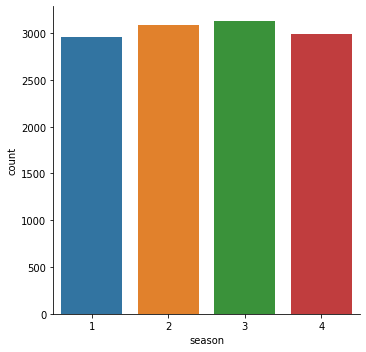

In [14]:
sn.factorplot(x='season',data=df_train,kind='count',size=5,aspect=1)

##### Year

In [15]:
df_train.year.value_counts()

1    6104
0    6061
Name: year, dtype: int64

More rentals at second year (2012)

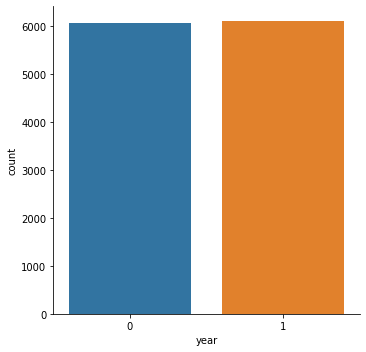

In [16]:
sn.factorplot(x='year',data=df_train,kind='count',size=5,aspect=1)

##### Month

In [17]:
df_train.month.value_counts()

12    1048
5     1046
3     1042
7     1038
10    1030
6     1027
8     1023
11    1011
9     1002
4     1001
1      968
2      929
Name: month, dtype: int64

From the function above we can infer that more rentals take place in December which is unexpected because we saw earlier that Winter has not as many bike rentals as Summer and Spring.

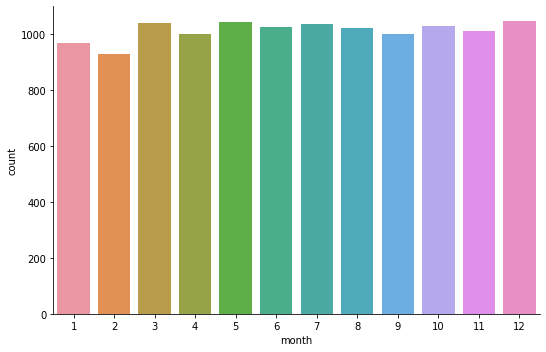

In [18]:
sn.factorplot(x='month',data=df_train,kind='count',size=5,aspect=1.5)

##### Hour

In [19]:
df_train.hour.value_counts()

9     518
20    517
10    515
12    514
21    513
19    512
11    512
13    511
17    510
23    510
0     510
5     509
15    509
18    505
2     504
22    504
1     504
6     503
14    503
8     503
16    502
7     499
3     490
4     488
Name: hour, dtype: int64

From the fuction above we can see the distribution of bike rentals throughout the day.

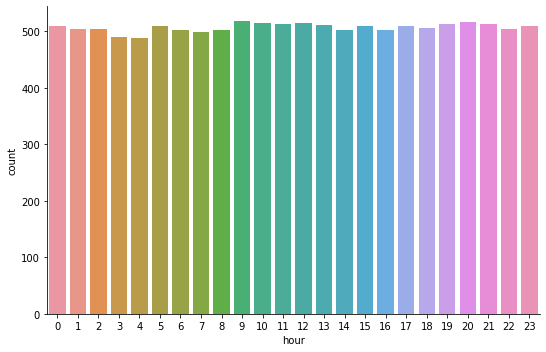

In [20]:
sn.factorplot(x='hour',data=df_train,kind='count',size=5,aspect=1.5)

##### Holiday

In [21]:
df_train.holiday.value_counts()

0    11837
1      328
Name: holiday, dtype: int64

We can infer from the function above that people rent bikes at non-vacation days at higher rate than at vacation ones.

D:\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Anaconda\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


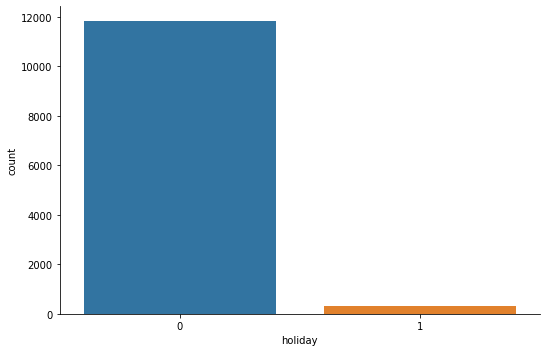

In [12]:
sn.factorplot(x='holiday',data=df_train,kind='count',size=5,aspect=1.5)


##### Weekday

In [23]:
df_train.weekday.value_counts()

6    1776
4    1763
0    1762
5    1737
3    1730
2    1704
1    1693
Name: weekday, dtype: int64

The number of rentals is distributed at weekdays.

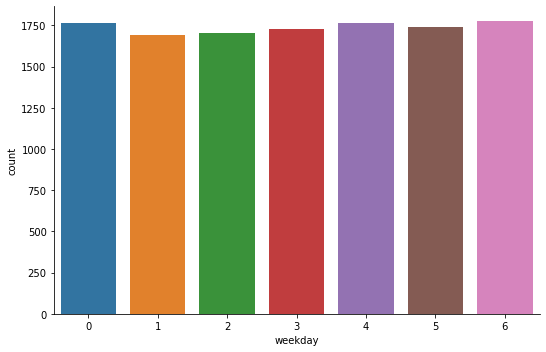

In [35]:
sn.factorplot(x='weekday',data=df_train,kind='count',size=5,aspect=1.5)

##### Workingday

In [29]:
df_train.workingday.value_counts()

1    8299
0    3866
Name: workingday, dtype: int64

We have more bike rentals at working days.

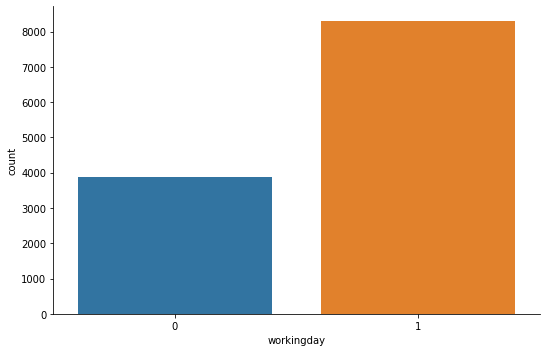

In [36]:
sn.factorplot(x='workingday',data=df_train,kind='count',size=5,aspect=1.5)


##### Weather

In [26]:
df_train.weather.value_counts()

1    8004
2    3127
3    1031
4       3
Name: weather, dtype: int64

1: Clear, Few clouds, Partly cloudy, Partly cloudy | 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist | 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds | 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog temp

- At days with heavy rain,ice pallets,thunderstorms and mists or foggy days with or without snow, we have only 3 rentals at train set. 
- At days with clear weather we have the most rentals(8004).
- At days with cloudy weather the number is diminishing .
- At days with light snow we have a few rentals but this number continues to be smaller than the corresponding one with clear weather.

So the weather feature is very important for our model.

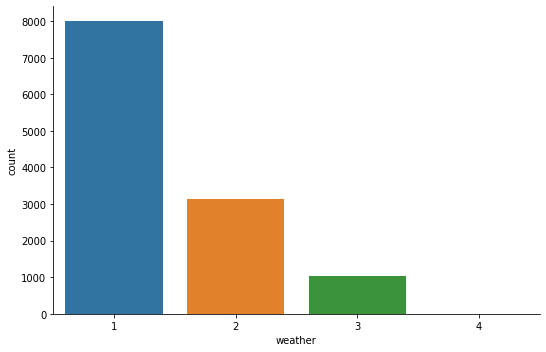

In [27]:
sn.factorplot(x='weather',data=df_train,kind='count',size=5,aspect=1.5)

#### Numerical Features

[Text(0.5, 1.0, 'Relation between windspeed and count')]

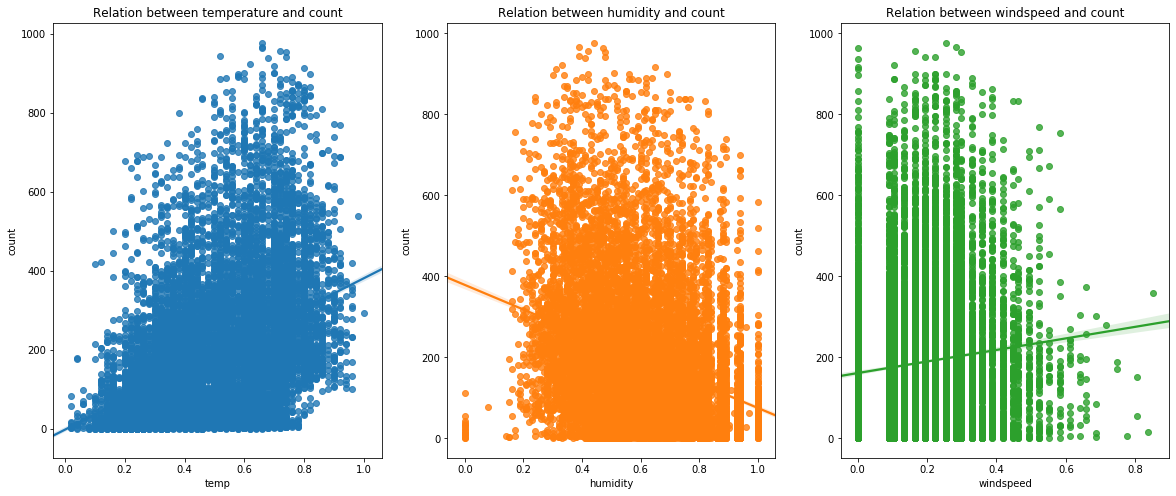

In [28]:
# Regression plot is used to verify if a pattern can be observed between `count` and numerical variables

fig,[ax1,ax2,ax3] = plt.subplots(ncols = 3, figsize = (20,8))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

sn.regplot(x = 'temp', y = 'count',data = df_train, ax = ax1)
ax1.set(title="Relation between temperature and count")
sn.regplot(x = 'humidity', y = 'count',data = df_train, ax = ax2)
ax2.set(title="Relation between humidity and count")
sn.regplot(x = 'windspeed', y = 'count',data = df_train, ax = ax3)
ax3.set(title="Relation between windspeed and count")

As we see ,we can't infer something useful from this plots for our model.

Visualisation of variation for all the continuous variables using histograms.

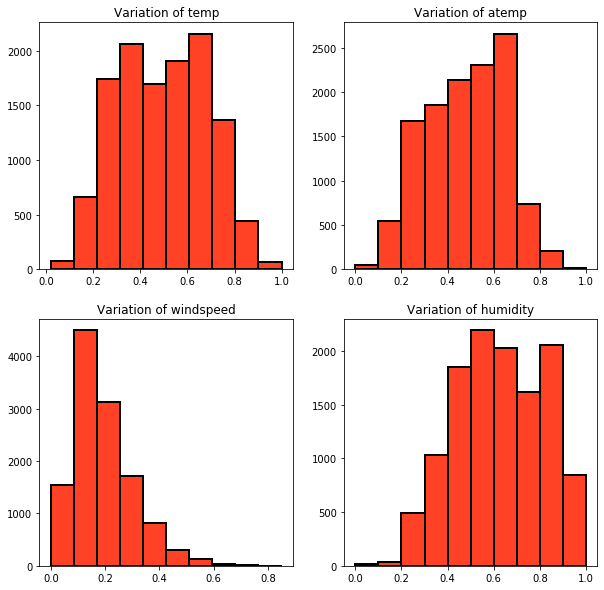

In [29]:
fig,axes = plt.subplots(2,2)
axes[0,0].hist(x="temp",data=df_train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of temp")
axes[0,1].hist(x="atemp",data=df_train,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of atemp")
axes[1,0].hist(x="windspeed",data=df_train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of windspeed")
axes[1,1].hist(x="humidity",data=df_train,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of humidity")
fig.set_size_inches(10,10)

Now we make a heatmap to show us the correlation between the features.

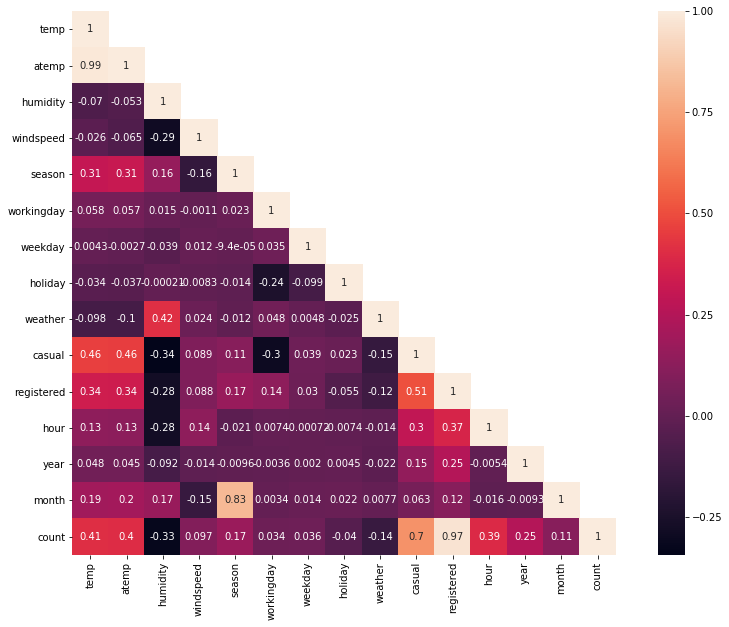

In [30]:
data_corr = df_train[['temp', 'atemp', 'humidity', 'windspeed','season' ,'workingday', 'weekday' , 'holiday'  ,'weather' , 'casual', 'registered','hour','year','month', 'count']].corr()
mask = np.array(data_corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(15, 10))
sn.heatmap(data_corr, mask=mask, vmax=1, square=True, annot=True)

- We drop atemp feature,on the grounds that is strongly correlated with temp feature. 

- Casual and registered contain direct information about the bike sharing count which we want to predict (data leakage). Therefore they are not considered in the feature set.

- Windspeed has little correlation with count.

In [12]:
df_train = df_train.drop(['atemp', 'casual', 'registered', 'windspeed'], axis=1)

In [13]:
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,humidity,count
0,4,0,11,0,0,2,1,1,0.56,0.64,22
1,1,0,2,21,0,6,0,1,0.28,0.65,68
2,4,1,11,12,0,3,1,1,0.44,0.41,344
3,1,1,1,7,0,2,1,2,0.18,0.93,222
4,1,1,3,16,0,1,1,1,0.30,0.45,210


In [39]:
df_train.shape

(12165, 11)

We did 1-hot encoding to variables 'month', 'year' in following lines, first at train set and then at test set. We can apply this procedure only to categorical variables. We ended up to do this to these 2 variables after several tests and combinations with other variables.
- We tried 1-hot encoding to 'weather' but we observed that number 4 (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog temp) did not exist in test set so we could not create 2 tables (train + test) with the same number of columns.
We saw from the heatmap that 'hour' and 'season' are very important for our model so we tried to apply 1-hot encoding.
- As for the 'hour', they had been created so many feature columns and this led the model to perform low despite the fact that we tried to apply PCA method to decrease the dimensionality.
- As for the 'season', results were not good neither by itself nor when we tried to combine it with 'month' and 'year'.

We could have combined 'season' and 'year' but we observed from the heatmap that 'season' and 'month' are strongly correlated so we decided to use only the one variable from these two.

In [13]:
hour=pd.get_dummies(df_train['year'],prefix='year')
df_train=pd.concat([df_train,hour],axis=1)
df_train.head()


,season,year,month,hour,holiday,weekday,workingday,weather,temp,humidity,count,year_0,year_1
0,4,0,11,0,0,2,1,1,0.56,0.64,22,1,0
1,1,0,2,21,0,6,0,1,0.28,0.65,68,1,0
2,4,1,11,12,0,3,1,1,0.44,0.41,344,0,1
3,1,1,1,7,0,2,1,2,0.18,0.93,222,0,1
4,1,1,3,16,0,1,1,1,0.30,0.45,210,0,1


1-hot encoding for month feature.

In [14]:
hour=pd.get_dummies(df_train['month'],prefix='month')
df_train=pd.concat([df_train,hour],axis=1)
df_train.head()


,season,year,month,hour,holiday,weekday,workingday,weather,temp,humidity,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,4,0,11,0,0,2,1,1,0.56,0.64,...,0,0,0,0,0,0,0,0,1,0
1,1,0,2,21,0,6,0,1,0.28,0.65,...,0,0,0,0,0,0,0,0,0,0
2,4,1,11,12,0,3,1,1,0.44,0.41,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,7,0,2,1,2,0.18,0.93,...,0,0,0,0,0,0,0,0,0,0
4,1,1,3,16,0,1,1,1,0.30,0.45,...,1,0,0,0,0,0,0,0,0,0


In [15]:
hour=pd.get_dummies(df_test['year'],prefix='year')
df_test=pd.concat([df_test,hour],axis=1)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,year_0,year_1
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478,0,1
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478,0,1
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836,1,0
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239,0,1
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000,0,1


In [16]:
hour=pd.get_dummies(df_test['month'],prefix='month')
df_test=pd.concat([df_test,hour],axis=1)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,1,20,0,4,1,1,0.26,0.2121,...,0,0,0,0,0,0,0,0,0,0
1,4,1,10,15,0,5,1,1,0.52,0.5000,...,0,0,0,0,0,0,0,1,0,0
2,1,0,1,10,0,0,0,1,0.22,0.2121,...,0,0,0,0,0,0,0,0,0,0
3,3,1,8,18,0,3,1,1,0.74,0.6667,...,0,0,0,0,0,1,0,0,0,0
4,1,1,2,8,0,1,1,1,0.24,0.2424,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_train = df_train.drop(['year','month'], axis=1)

Some data types need to be changed from numerical to categorical in order for the model to interpret better these variables.

In [18]:
df_train['weekday'] = df_train.weekday.astype('category')
df_train['hour'] = df_train.hour.astype('category')
df_train['holiday'] = df_train.holiday.astype('category')
df_train['weather'] = df_train.weather.astype('category')
df_train['workingday'] = df_train.workingday.astype('category')
df_train['season'] = df_train.season.astype('category')

In [20]:
df_train.dtypes

season        category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
humidity       float64
count            int64
year_0           uint8
year_1           uint8
month_1          uint8
month_2          uint8
month_3          uint8
month_4          uint8
month_5          uint8
month_6          uint8
month_7          uint8
month_8          uint8
month_9          uint8
month_10         uint8
month_11         uint8
month_12         uint8
dtype: object

In [23]:
df_train.shape

(12165, 23)

In [79]:
df_train.head(3)

,season,hour,holiday,weekday,workingday,weather,temp,humidity,count,year_0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,4,0,0,2,1,1,0.56,0.64,22,1,...,0,0,0,0,0,0,0,0,1,0
1,1,21,0,6,0,1,0.28,0.65,68,1,...,0,0,0,0,0,0,0,0,0,0
2,4,12,0,3,1,1,0.44,0.41,344,0,...,0,0,0,0,0,0,0,0,1,0


## Model Building

Because outlier value will bring some big error,we used log to avoid outliers.

In [19]:
X = np.array(df_train.drop(df_train[[ 'count']], 1))

y = df_train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

y_trainlog = np.log1p(y_train)

### KNN

The k-nearest neighbors (KNN) algorithm is a supervised machine learning algorithm that can be used to solve both classification and regression problems. It assumes that similar things exist in close proximity. In other words, similar things are near to each other so it calculates the straight-line distance  between these points on a graph. We present below its implementation: 
1. Load the data.
2. Initialize K to your chosen number of neighbors.
3. For each example in the data
    - 3.1 Calculate the distance between the query example and the current example from the data.
    - 3.2 Add the distance and the index of the example to an ordered collection.
4. Sort the ordered collection of distances and indices from smallest to largest (in ascending order) by the distances.
5. Pick the first K entries from the sorted collection.
6. Get the labels of the selected K entries.
7. If regression (a real number as output), return the mean of the K labels.
8. If classification (a discrete value as output), return the mode of the K labels.

We tried to apply KNN to our model but as you can see below, it did not improve our RMSLE score.

In [24]:
knn = KNeighborsRegressor(n_jobs=-1)
knn.fit(X_train, y_trainlog)
y_pred= knn.predict(X_test)

- n_jobs : The number of parallel jobs to run for neighbors search,-1 means using all processors.

In [25]:
True in (y_pred < 0)

False

In [26]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [27]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred))))
print('R2:', r2_score(y_test, np.exp( y_pred)))

RMSLE: 0.39962138873333625
R2: 0.8801970604914774


[Text(0.5, 1.0, 'Comparison between the actual vs predicted values from KNN')]

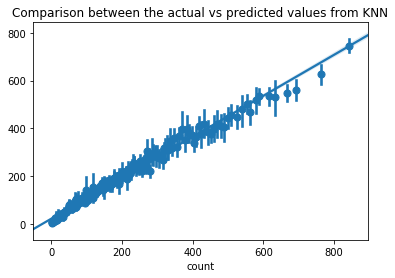

In [28]:
ax = sn.regplot(y_test,np.exp( y_pred), x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values from KNN")

### XGBoost Regressor

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models. The key features of this algorithm are :
1. Sparse Aware implementation with automatic handling of missing data values.
2. Block Structure to support the parallelization of tree construction.
3. Continued Training so that you can further boost an already fitted model on new data.

Our RMSLE score was not improved with the implementation of this algorithm so we did not apply it to our model.

In [30]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train, y_trainlog)
y_pred= xg_reg.predict(X_test)

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:47:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [31]:
True in (y_pred < 0)

False

In [32]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [33]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred))))
print('R2:', r2_score(y_test, np.exp( y_pred)))

RMSLE: 0.3890022022240694
R2: 0.8388085886587142


[Text(0.5, 1.0, 'Comparison between the actual vs predicted values from XGB')]

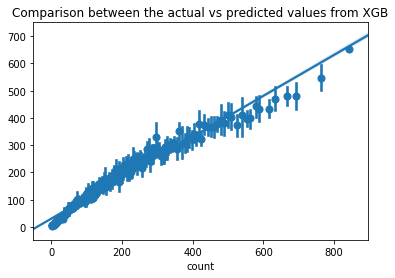

In [34]:
ax = sn.regplot(y_test,np.exp( y_pred), x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values from XGB")

### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples 
of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) 
lead to fully grown and unpruned trees which can potentially be very large on some data sets.

In [35]:
clf = RandomForestRegressor(n_jobs=-1, random_state=0)
clf.fit(X_train, y_trainlog)
y_pred = clf.predict(X_test)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


- n_jobs : The number of parallel jobs to run for neighbors search,-1 means using all processors.
- Controls both the randomness of the bootstrapping of the samples used when building trees and the sampling of the features to consider when looking for the best split at each node, 0 is a popular integer random seed.

In [36]:
True in (y_pred < 0)

False

In [37]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [38]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred))))
print('R2:', r2_score(y_test, np.exp( y_pred)))

RMSLE: 0.34509249950869675
R2: 0.9297074367985756


[Text(0.5, 1.0, 'Comparison between the actual vs predicted values from Random Forest Regressor')]

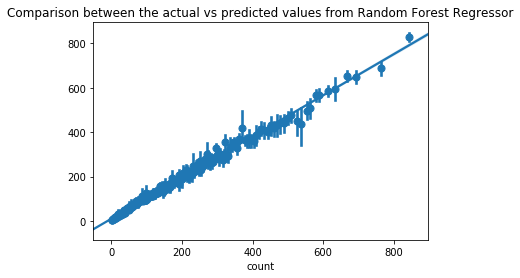

In [40]:
ax = sn.regplot(y_test,np.exp( y_pred), x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values from Random Forest Regressor")

### Random Forest Regressor with GridSearch

In [52]:
parameters = {'n_estimators': [200, 400], 'max_depth': [15, 25]}
clf_cv = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)
clf_cv.fit(X_train, y_trainlog)
y_pred = clf_cv.best_estimator_.predict(X_test)

- So we use "n_estimators" for the number of trees in the forest and max_depth for the max depth of these trees.
We put these parameters in arrays and our algorithm(in get score method) will choose the best values for our estimator.
- cv=5 : Determines the cross-validation splitting strategy. 5 is the number of folds in a (Stratified)KFold

In [53]:
True in (y_pred < 0)

False

In [54]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [55]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred))))
print('R2:', r2_score(y_test, np.exp( y_pred)))

RMSLE: 0.32624763419688274
R2: 0.9375337258790005


[Text(0.5, 1.0, 'Comparison between the actual vs predicted values from Random Forest Regressor')]

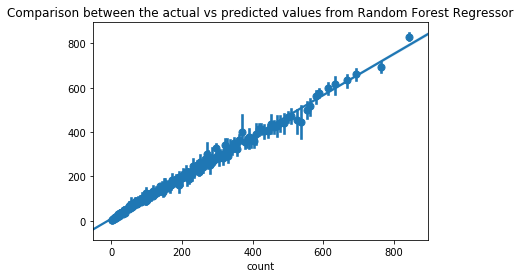

In [56]:
ax = sn.regplot(y_test,np.exp( y_pred), x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values from Random Forest Regressor")

###  Gradient Boosting Regressor

In [47]:
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)
gbm.fit(X_train,y_trainlog)
y_pred = gbm.predict(X_test)

- alpha : These regularization parameter limits how extreme the weights (or influence) of the leaves in a tree can become.

In [48]:
True in (y_pred < 0)

False

In [49]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [50]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred))))
print('R2:', r2_score(y_test, np.exp( y_pred)))

RMSLE: 0.2959370381825778
R2: 0.9457606742413951


[Text(0.5, 1.0, 'Comparison between the actual vs predicted values from Gradient Boosting Regressor')]

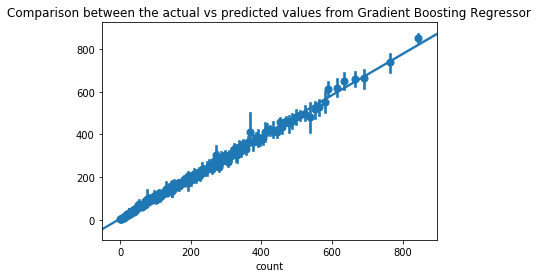

In [51]:
ax = sn.regplot(y_test,np.exp( y_pred), x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values from Gradient Boosting Regressor")

We fit the 2 regressors (train our model)
gbm as GradientBoostingRegressor
and 
clf_cv as RandomForestRegressor with GridSearchCV.
GridSearch let us combine an estimator with a grid search preamble to tune hyper-parameters.
This method picks the optimal parameter from  grid search and uses it with our estimator(RandomForestRegressor).

In [33]:
def get_score(X_train, X_test, y_train, y_test):
    y_trainlog = np.log1p(y_train)
    clf_cv.fit(X_train, y_trainlog)
    gbm.fit(X_train, y_trainlog)
    y_pred1 = clf_cv.best_estimator_.predict(X_test)
    y_pred = gbm.predict(X_test)
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred))))
    print('R2:', r2_score(y_test, np.exp( y_pred)))
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred1))))
    print('R2:', r2_score(y_test, np.exp( y_pred1)))
    #return np.sqrt(mean_squared_log_error(y_test,np.exp( y_pred)))
    return y_pred

##### Cross Validation
Cross Validation improved our score a lot.
Its a very usefull tool to avoid overfitting and also gave us an idea of how our code will perform on other data.
Splits' performance in cross validation is related with the amount of data used in the model.
We tried many combinations about cross validation but the 10-split gave us the best results,
more or less splits will end up scoring less points.

In [34]:
kf = StratifiedKFold(n_splits = 10)

We observed that there is a relation between 'count' ,  'registered'  and 'casual' (registered + casual = count) so we tried to predict 'registered' and 'casual' separately  and then we  added the results of these 2 predictions. Nevertheless the results were worse than before (prediction of 'count' without the mixture of 'registered' and 'casual') so we did not apply this to our model.

In [35]:
X = np.array(df_train.drop(df_train[[ 'count']], 1))

y = df_train['count']



gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)

sc =[]
y_pred=[]
y_pred1=[]
y_t=[]

clf = RandomForestRegressor(n_jobs=-1, random_state=0)
parameters = {'n_estimators': [200, 400], 'max_depth': [15, 25]}
clf_cv = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)

for train_index,test_index in kf.split(X,y):
    X_train, X_test, y_train, y_test = X[train_index],X[test_index],y[train_index],y[test_index]
    y_t.append(y_test)
    y_pred.append(get_score(X_train, X_test, y_train, y_test))
    
    
    
    
    


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


RMSLE: 0.2715540058182328
R2: 0.9617599993848172
RMSLE: 0.2902213921319653
R2: 0.9441878029742011
RMSLE: 0.27987900005224275
R2: 0.9542517335403785
RMSLE: 0.3078838792966988
R2: 0.9416330459308445
RMSLE: 0.284590531031506
R2: 0.9403240565644932
RMSLE: 0.3124018559314789
R2: 0.937229033138751
RMSLE: 0.29983443027317014
R2: 0.934504982151679
RMSLE: 0.31692625585603335
R2: 0.9273686475412997
RMSLE: 0.3091153373829097
R2: 0.9396214585057495
RMSLE: 0.3325847789005261
R2: 0.9334417985897975
RMSLE: 0.31504412331684223
R2: 0.9447004136446796
RMSLE: 0.331744621251857
R2: 0.9302901618097535
RMSLE: 0.3088888835495268
R2: 0.9322636721527194
RMSLE: 0.33848161258009357
R2: 0.9218556643415223
RMSLE: 0.31668820320065644
R2: 0.9279689118225144
RMSLE: 0.34385492271479606
R2: 0.9298580603807783
RMSLE: 0.31802210599515107
R2: 0.9260928858404053
RMSLE: 0.3387523284743355
R2: 0.9244622133820288
RMSLE: 0.3190798207314306
R2: 0.9005578021079977
RMSLE: 0.3615811165500343
R2: 0.8887062582116336


In [36]:
X_train.shape

(11257, 22)

In [37]:
y_train.shape

(11257,)

## Feature Importance from Gradient Boosting Regressor

In [38]:
###importance of features for Gradient Boosting algorithm 
importances = gbm.feature_importances_
print(importances)

[2.67656532e-02 7.63018661e-01 1.53748251e-03 1.08289457e-02
 6.17872643e-02 1.47211345e-02 6.96985775e-02 1.60761878e-02
 1.56799773e-02 1.32956583e-02 1.12655126e-03 6.11208622e-04
 3.32888700e-04 8.01344916e-04 5.39975246e-04 2.12670754e-04
 9.22856655e-05 2.89319542e-04 1.35153184e-04 3.61349847e-04
 5.53295860e-04 1.53441422e-03]


In [39]:
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
features=['season','hour','holiday','weekday','workingday','weather','temp','humidity','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature hour (0.763019)
2. feature temp (0.069699)
3. feature workingday (0.061787)
4. feature season (0.026766)
5. feature humidity (0.016076)
6. feature year_0 (0.015680)
7. feature weather (0.014721)
8. feature year_1 (0.013296)
9. feature weekday (0.010829)
10. feature holiday (0.001537)
11. feature month_12 (0.001534)
12. feature month_1 (0.001127)
13. feature month_4 (0.000801)
14. feature month_2 (0.000611)
15. feature month_11 (0.000553)
16. feature month_5 (0.000540)
17. feature month_10 (0.000361)
18. feature month_3 (0.000333)
19. feature month_8 (0.000289)
20. feature month_6 (0.000213)
21. feature month_9 (0.000135)
22. feature month_7 (0.000092)


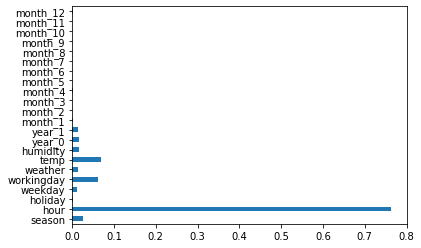

In [41]:
(pd.Series(gbm.feature_importances_, index=features)
   .plot(kind='barh')) 

## Comparison between the actual vs predicted values from Gradient Boosting Regressor for all cross-validation splits.

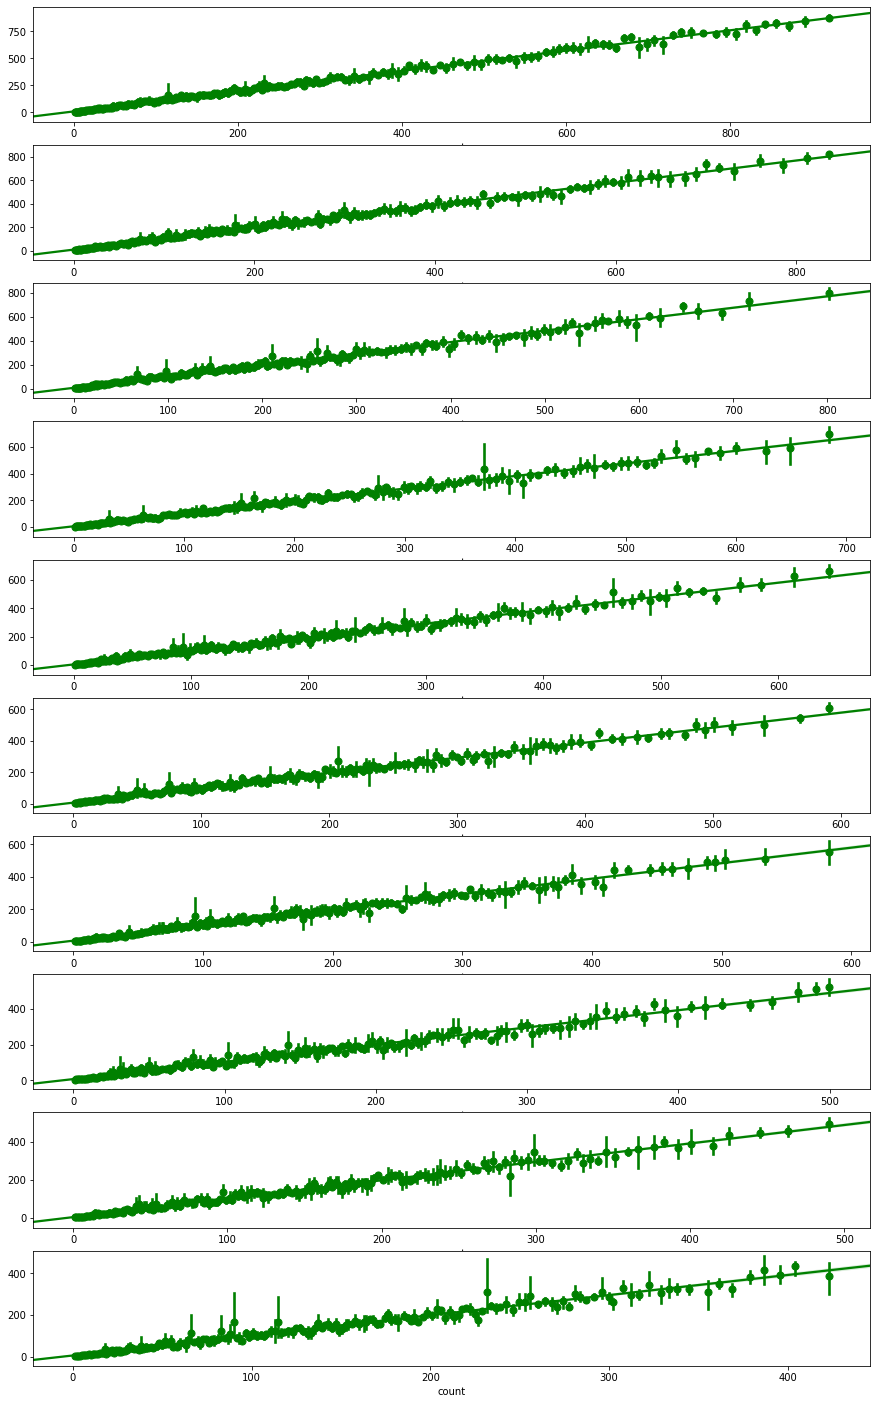

In [46]:
fig,[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10] = plt.subplots(nrows=10, figsize=(15,25))
sn.regplot(y_t[0],np.exp( y_pred[0]), x_bins = 200,color='g',ax=ax1)
sn.regplot(y_t[1],np.exp( y_pred[1]), x_bins = 200,color='g',ax=ax2)
sn.regplot(y_t[2],np.exp( y_pred[2]), x_bins = 200,color='g',ax=ax3)
sn.regplot(y_t[3],np.exp( y_pred[3]), x_bins = 200,color='g',ax=ax4)
sn.regplot(y_t[4],np.exp( y_pred[4]), x_bins = 200,color='g',ax=ax5)
sn.regplot(y_t[5],np.exp( y_pred[5]), x_bins = 200,color='g',ax=ax6)
sn.regplot(y_t[6],np.exp( y_pred[6]), x_bins = 200,color='g',ax=ax7)
sn.regplot(y_t[7],np.exp( y_pred[7]), x_bins = 200,color='g',ax=ax8)
sn.regplot(y_t[8],np.exp( y_pred[8]), x_bins = 200,color='g',ax=ax9)
sn.regplot(y_t[9],np.exp( y_pred[9]), x_bins = 200,color='g',ax=ax10)

## Kaggle Submission

Now we will use the fitted model to make predictions for the given test set. First we load the test set and then follow the same preprocessing steps as for train set

In [28]:
filename = 'dataset/test.csv'

df_test = pd.read_csv(filename)
df_test.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


In [29]:
df_test.shape

(5214, 12)

In [30]:
df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [31]:
season=pd.get_dummies(df_test['year'],prefix='year')
df_test=pd.concat([df_test,season],axis=1)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,year_0,year_1
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478,0,1
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478,0,1
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836,1,0
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239,0,1
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000,0,1


In [32]:
season=pd.get_dummies(df_test['month'],prefix='month')
df_test=pd.concat([df_test,season],axis=1)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,1,20,0,4,1,1,0.26,0.2121,...,0,0,0,0,0,0,0,0,0,0
1,4,1,10,15,0,5,1,1,0.52,0.5000,...,0,0,0,0,0,0,0,1,0,0
2,1,0,1,10,0,0,0,1,0.22,0.2121,...,0,0,0,0,0,0,0,0,0,0
3,3,1,8,18,0,3,1,1,0.74,0.6667,...,0,0,0,0,0,1,0,0,0,0
4,1,1,2,8,0,1,1,1,0.24,0.2424,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_test = df_test.drop(['atemp', 'windspeed'], axis=1)

In [34]:
df_test = df_test.drop(['year', 'month'], axis=1)

In [35]:
df_test.shape


(5214, 22)

In [36]:
df_test['weekday'] = df_test.weekday.astype('category')
df_test['hour'] = df_test.hour.astype('category')
df_test['holiday'] = df_test.holiday.astype('category')
df_test['weather'] = df_test.weather.astype('category')
df_test['workingday'] = df_test.workingday.astype('category')
df_test['season']  = df_test.season.astype('category')

In [37]:
df_test.shape

(5214, 22)

In [38]:
df_test.dtypes

season        category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
humidity       float64
year_0           uint8
year_1           uint8
month_1          uint8
month_2          uint8
month_3          uint8
month_4          uint8
month_5          uint8
month_6          uint8
month_7          uint8
month_8          uint8
month_9          uint8
month_10         uint8
month_11         uint8
month_12         uint8
dtype: object

In [39]:
y_pred = gbm.predict(df_test)
y_pred1 = clf_cv.predict(df_test)

We applied the combination of two models (Random Forest Regressor, Gradient Boosting Regressor) and we observed that Gradient Boosting gave us the best score so it was more influencial on our predictions than Random Forest Regressor. We tried the following combinations: 0.6/0.4 , 0.8/0.2 , 0.75/0.25 but the most effective result was this one: 0.7/0.3 se we applied this. We also tried to keep the average between the predictions of these two methods but this did not work.

In [40]:
y_pred = y_pred*0.7 + y_pred1*0.3

In [41]:
True in (y_pred < 0)

False

In [42]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [43]:
submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = np.exp(y_pred)

In [44]:
submission.to_csv("submission78.csv", index=False)